# Demo 1: FEDS Archived Perimeters V.S. NIFC Historic Perimeters for Kincade Fire 2019

### Summary

This notebook demonstrates an Object Oriented Programming (OOP) implementation of a benchmarking system to compare a FEDS fire perimeter against other fire perimeter data sources, and then store in an output object. 

Sources for demonstration:
- FEDS archived perimeters, labeled as `"public.eis_fire_lf_perimeter_archive"`
- NIFC historic perimeters, labeled as `"nifc_interagency_history_local"`

The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

#### Motivation 
FEDS-PEC eliminates the need for users to recreate/repeat solutions when conducting geospatial data evaluations. By leveraging this module, researchers and analysts can quickly and efficiently compare the FEDS fireperimeter dataset against a reference data set of their choosing. Users can focus their efforts on dataset selection and analysis, rather than spending time implementing and testing software for comparisons and calculations.

#### Disclaimer
The serializing/plotting portion is incomplete, this notebook does not demonstrate persistence of output. Plotting is also demoed but not yet implemented in the classes as intended.

### User Inputs for Comparison: time, bbox, FEDS set, reference set

Note for inputs:

FEDS Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive) according to documentation. Please see **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

Reference Input: See **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

In [2]:
import sys
sys.path.append('/projects/my-public-bucket/VEDA-PEC')

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2019
month_start = 10
day_start = 23
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2019
month_stop = 11
day_stop = 14
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
# search_bbox = ["-106.8", "24.5", "-72.9", "37.3"] # api demo
search_bbox = ["-122.887312", "38.560242", "-122.601345", "38.813395"] # kincade fire, 38.560242, -122.887312 left 38.813395, -122.601345 right

day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api" # or "local
feds_limit = 1000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False # False or a valid query: e.g. "farea>5 AND duration>2"
feds_apply_finalfire = True # set this to true if you want the only the latest fireID to be taken per unique FireID

# REFERENCE INPUT SETTINGS 
ref_title = "nifc_interagency_history_local" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS
maap_username = "ksharonin" # per user, in order to store into user's own public bucket
name_for_output_file = f"firenrt_vs_nifc_interagency_{year_start}_{search_bbox[0]}_{search_bbox[1]}_{search_bbox[2]}_{search_bbox[3]}" # name for your file EXCLUDING PREFIX!
output_format = "txt" # prefix txt, json, others coming
print_on = True # print to jupyter nb
plot_on = False # display plot of comparison

# NOTE: for now don't modify this, just showing you how url is contructed
# [ why would the output need to be maap? Why not just let the user pass a path?]
output_maap_url = f"s3://maap-ops-workspace/shared/{maap_username}/{name_for_output_file}.{output_format}" # maap url to save; MUST BE MAAPS URL! (for now at least to make things simple

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [3]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of FEDS in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed


CALCULATED A RESULT: POLYGON FEDS AT INDEX 41 AGAINST REFERENCE POLYGON AT INDEX 11287:
Ratio: 1.0768937433017958, Accuracy: 1.5525343121533373, Precision: 0.8841178733805377, Recall: 0.9521010061847904, IOU: 0, F1 0.9168509551876862, Symmetric Ratio: 0.1726917309322174
All measurements in units metre


### Visualize/Print Results

As noted above, this plotting will be moved into the classes. For now, it is demonstrating the same functionality it will have in the future. It uses the returned indices to pick out polygons of interest (41 was the feds and 11287 was the reference used for the calculation above)

In [5]:
feds_kincade = feds_firenrt.polygons[feds_firenrt.polygons['index'] == 41] # <-- thats the index in (41, 11287)! 
feds_kincade.head()

,geometry,duration,farea,fireid,flinelen,fperim,meanfrp,n_newpixels,n_pixels,ogc_fid,pixden,t,index
41,"POLYGON ((-122.869 38.759, -122.869 38.759, -1...",8.0,338.889971,F15031,0.0,95.945675,0.0,0,1836,103269,5.417688,2019-11-04T12:00:00,41


In [6]:
nifc_match = nifc_search.polygons[nifc_search.polygons['index'] == 11287] # <-- thats the index in (41, 11287)! 
nifc_match.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,UNIT_ID,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry,DATE_NOT_NONE,DATE_LEN_VALID,DATE_CUR_STAMP,index
11287,11288,GPS Ground,20191110,None,42478,None,2019-CALNU-00019376,2019,00019376,KINCADE,CALNU,None,Wildfire,77762.14,None,CalFire FRAP,CDF,2019.0,5.171126e+08,238568.857449,"MULTIPOLYGON (((-122.814 38.566, -122.814 38.5...",True,True,2019-11-10,11287


SAMPLE PLOTTING FEDS V. REFERENCE


BLUE: FEDS. Kincade Fire Estimate
GOLD: NIFC Reference Match


FEDS date: 2019-11-04T12:00:00
NIFC Reference date: 2019-11-10T00:00:00.000000000




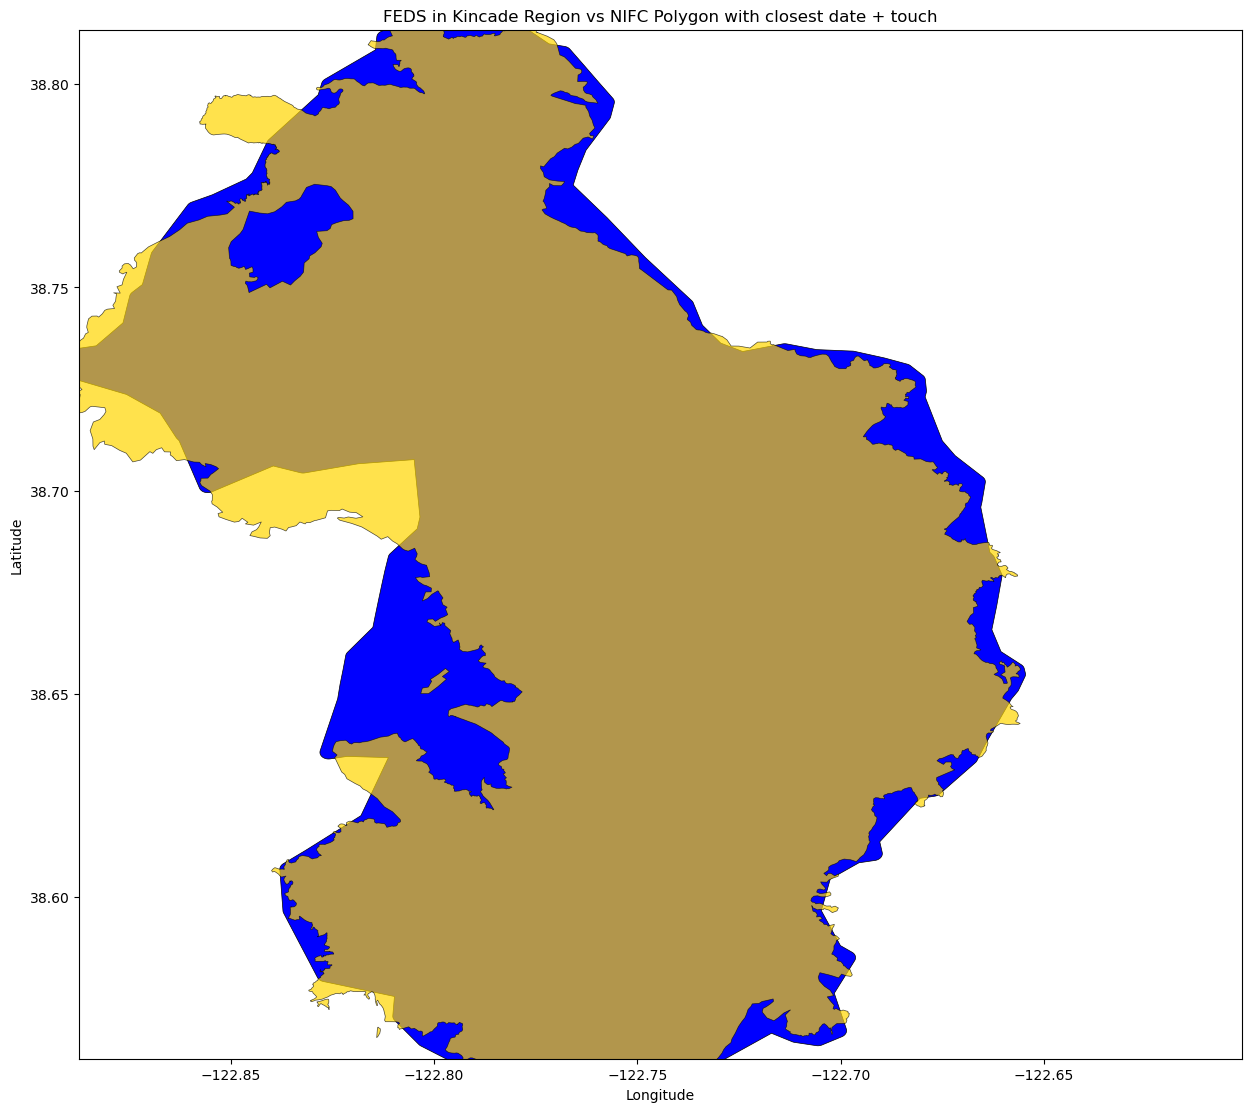

In [7]:
# for debugging purposes this is here

import matplotlib.pyplot as plt

print('SAMPLE PLOTTING FEDS V. REFERENCE')
print('\n')
print('BLUE: FEDS. Kincade Fire Estimate')
print('GOLD: NIFC Reference Match')
print('\n')
print(f"FEDS date: {feds_kincade.t.values[0]}")
print(f"NIFC Reference date: {nifc_match['DATE_CUR_STAMP'].values[0]}")
print('\n')

fig, ax = plt.subplots(figsize=(15, 15))

# bound box as defined by us
ax.set_xlim(-122.887312, -122.601345)
ax.set_ylim(38.560242, 38.813395)

# feds_kincade.t.values[0]

# plot search results/what calculation is pulling from
v = feds_kincade.plot(ax=ax, legend=True, label="FEDS Kincade Fire Estimate", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_match.plot(ax=ax, legend=True, label="NIFC Nearest Date + Intersection", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("FEDS in Kincade Region vs NIFC Polygon with closest date + touch")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
